In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import math
import matplotlib.pyplot as plt

%matplotlib inline

The first step of the analysis is to make some assumptions about the DDS engine we'll be working with here. 

I'm setting a stretch goal of a 100MHz clock frequency/sample rate for the DDS, and an accumulator depth of 32 bits. 

That gives us a frequency resolution of:

$F_{res} = \frac{F_{clock}}{2^{N}} = \frac{100 MHz}{2^{32}} = ~0.02 Hz$

To save some brain sweat, I'm going to write two quick functions to interchange frequencies and tuning words:

In [112]:
# Returns the frequency tuning word for a desired frequency output 
# Default: 
#    - Sample rate/input clock = 100MHz
#    - Phase Accumulator depth = 32 bits
def freq_to_tuning(freq_out, sample_rate=100000000, acc_depth=32):
    return int((freq_out * (2**acc_depth))/sample_rate)

# Returns the frequency output for a given frequency tuning word
# Default: 
#    - Sample rate/input clock = 100MHz
#    - Phase Accumulator depth = 32 bits
def tuning_to_freq(tuning_word, sample_rate=100000000, acc_depth=32):
    return (tuning_word * sample_rate) / float(2 ** acc_depth)

Note, too, that these aren't perfect exchanges. There's some quantization error inherent in a digital system - that's the frequency resolution we calculated a second ago. You can see this by just jumping back and forth between formats, and noting the error between the conversions:

In [141]:
freq = 2822400
tuning = freq_to_tuning(freq)
freq_actual = tuning_to_freq(tuning)

error = ((freq_actual - freq)/freq) * 100
print(f"{freq} Hz signal: {tuning:#010x}")
print(f"{freq_actual} Hz signal: {tuning:#010x} ({error})")

2822400 Hz signal: 0x0739b024
2822399.977594614 Hz signal: 0x0739b024 (-7.938416231246222e-07)


There's also error introduced in the way that Python truncates rather than rounds when converting between `float` and `int`. Astute readers have likely noted that the _next_ value, `0x0739b025`, actually produces a lower-error signal. Tuning code `0x0739b025` produces an output of 2822400.0008776784 Hz rather than the original 2822399.977594614 Hz: 

In [142]:
tuning = tuning + 1
freq_actual = tuning_to_freq(tuning)
error = ((freq_actual - freq)/freq) * 100
print(f"{freq_actual} Hz signal: {tuning:#010x}")
print(f"{freq_actual} Hz signal: {tuning:#010x} ({error})")

2822400.0008776784 Hz signal: 0x0739b025
2822400.0008776784 Hz signal: 0x0739b025 (3.109688188483656e-08)


Worth noting: a typical uncompensated quartz crystal will vary around 25-50ppm in frequency. Whether or not this is something you need to lose speep over is specific to your application. Odds are, unless you are working with atomic clocks, this is a totally appropriate amount of jitter for your frequency synthesis application. Ethernet phys and Bluetooth ICs the world over happily run with oscillator reference tolerances in the 25ppm range, and reliably serve up phone calls, Spotify streams, and cat photos to people every day. 

Anywhoozles: using that rather gnarly 32 bit number `0x0739b025` as our genesis point, we can generate a sample phase accumulator output using the following code block:

Text(0.5, 1.0, 'DDS Output')

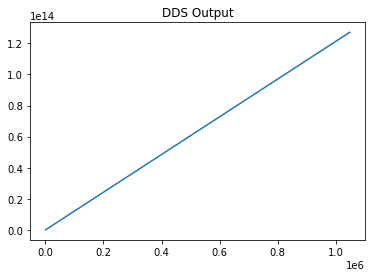

In [143]:
# Generates a phase accumulator output for a given tuning word
phase = [ 0 ]
while len(phase) < (2**20):
    phase.append(phase[-1] + tuning)

plt.plot(phase)
plt.title("DDS Output")

OK, great. The chart goes up, and to the right. (The business unit will be _ecstatic_.) Eventually, it's going to just roll over and keep on counting. That's not a big deal! This is a *phase* accumulator, and phase wraps around from $2\pi$ back to zero. 

This is fortunate in more than one regard. At some point, we're gonna need to convert _phase_ to _amplitude_. The easiest (and also fastest) way to do this is with a lookup table, or a simple ROM. If phase wasn't a parameter that rolled over, we'd be up shit creek without an infinite memory paddle. Instead of feeding all 2^32 possible phase accumulator values into a ~4GB of sine values, the accumulator instead gets _truncated_ down to its most significant bits - in this case, the 12 MSBs:

In [149]:
df_phase = pd.DataFrame(zip(phase, [tuning] * len(phase)), columns=['phase', 'tuning'])
df_phase['phase_trunc'] = np.bitwise_and(df_phase['phase'], 0xFFC00000)
df_phase['phase_trunc'] = np.right_shift(df_phase['phase_trunc'], 20)

A short function allows us to generate sine lookup ROMs really quickly:

In [150]:
# Generate a rom table of a sine wave with signed integers 
def generate_sin_rom(bits, rom_depth):
    # Subtract 1 from bit depth for signed data (msb is sign bit)
    amplitude = 2**(bit_depth-1)
    sin_rom = [int(amplitude * math.sin(a/rom_depth * 2 * math.pi)) for a in range(rom_depth)]
    return(sin_rom)

bit_depth = 12
rom_size = 4096
sin_rom = generate_sin_rom(bit_depth, rom_size)

...and a lambda function allows us to turn this into a sine wave, toot sweet.

<AxesSubplot:>

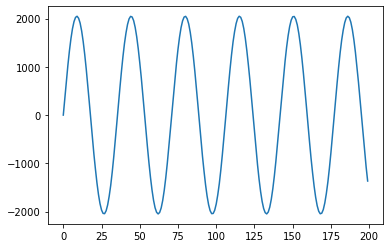

In [153]:
# Lambda function serves as phase-to-amplitude converter
df_phase['dds_out'] = df_phase['phase_trunc'].apply(lambda x: sin_rom[x])
df_phase['dds_out'][:200].plot()

<ipython-input-158-3c259a34ea80>:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(3,1,3)


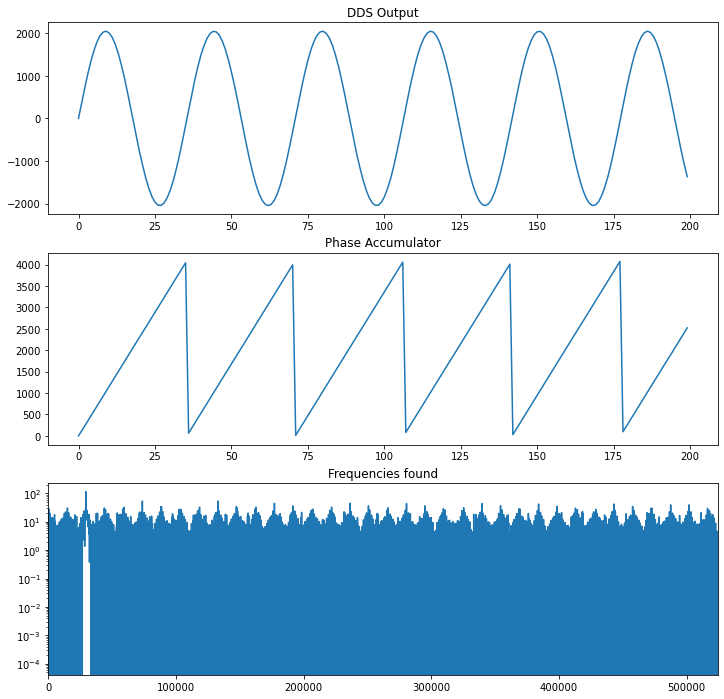

29595

In [158]:
data_fft = np.fft.fft(df_phase['dds_out'])
frequencies = np.abs(data_fft)
#freq_scale = frequencies * 2 / np.sum()
db_freqs = 20 * np.log10(frequencies/ (2**(bit_depth-1)))

plot_len = 200

fig = plt.figure(figsize=(12,12))
plt.subplot(3,1,1)
plt.plot(df_phase['dds_out'][:plot_len])
plt.title("DDS Output")

plt.subplot(3,1,2)
plt.plot(df_phase['phase_trunc'][:plot_len])
plt.title("Phase Accumulator")
 
plt.subplot(3,1,3)
ax = fig.add_subplot(3,1,3)
ax.set_yscale('log')
fft_index = int(len(frequencies)/2)
plt.plot(db_freqs[:fft_index])
 
plt.title("Frequencies found")
plt.xlim(0,fft_index)
plt.show()

np.argmax(frequencies)

In [74]:
data = [] 
with open('../output_results.txt') as f:
    for line in f:
        data.append(line.strip().split(','))
        
# Converts testbench data to ints
data = [data[0]] + [[int(j) for j in i] for i in data[1:]]

FileNotFoundError: [Errno 2] No such file or directory: '../output_results.txt'

In [4]:
df = pd.DataFrame(data[1:], columns=data[0])
df

,addr_tb,data_tb
0,0,0
1,1,0
2,2,0
3,3,0
4,4,3
...,...,...
499995,8475,-219
499996,8476,-222
499997,8477,-222
499998,8478,-222


<AxesSubplot:>

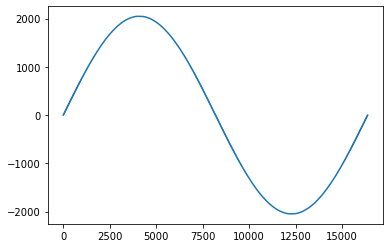

In [8]:
import matplotlib.pyplot as plt
df['data_tb'][:(4*4096)].plot()

In [30]:
import matplotlib.pyplot as plt
sp = np.fft.fft(df['data_tb'], n=8192)
sp

array([10668416.           +0.j        , -3562884.2774399 -1366.34907475j,
        -711589.69589066 -545.7825682j , ...,
        -305337.60550223 +351.28667048j,  -711589.69589066 +545.7825682j ,
       -3562884.2774399 +1366.34907475j])

In [25]:
len(sp)

1024

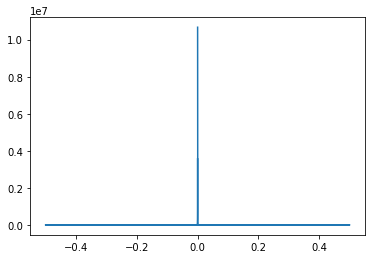

In [34]:
freq = np.fft.fftfreq(len(sp))
plt.plot(freq, np.abs(sp))
plt.show()

/Users/nreilly/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


<AxesSubplot:>

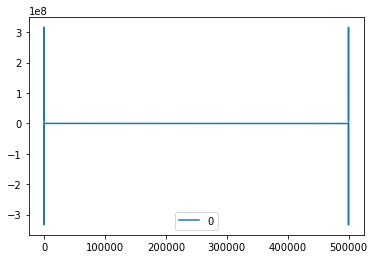

In [46]:
fft_data = np.fft.fft(df['data_tb'])

pd.DataFrame(fft_data).plot()

In [20]:
print(pd.__version__)

1.2.4
